In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.listdir("./")

['.ipynb_checkpoints', 'data', 'rock_typing.ipynb']

In [5]:
train = pd.read_excel("./data/NNM1_HUF and RT.xlsx", sheet_name="HFU_RT")
test = pd.read_excel("./data/BangaM1_HFU and RT.xlsx", sheet_name="HFU_RT")

In [6]:
train.columns

Index(['DEPTH', 'PoroRCA', 'PermRCA', 'PHIE_2014', 'RQI', 'PHIz', 'FZI',
       'Log FZI', 'Percentile', 'HFU_Rock Type', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')

In [7]:
test.columns

Index(['DEPTH', 'PoroRCA', 'PermRCA', 'PHIE', 'RQI', 'PHIz', 'FZI', 'Log FZI',
       'Percentile', 'HFU_RT', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')

In [88]:
new_column_names = {'DEPTH': "depth", 
        'PoroRCA': "porosity",
        'PermRCA': "permeability",
        'PHIE': "phie", 
        'PHIE_2014': "phie", 
        'RQI': "rqi",
        'PHIz': "phiz",
        'FZI': "fzi",
        'Log FZI': "logfzi",
        'Percentile': "percentile", 
        'HFU_RT': "rocktype",
        'HFU_Rock Type': "rocktype"}

In [89]:
train.shape, test.shape

((91, 16), (44, 16))

In [90]:
train = train.rename(columns=new_column_names)
test = test.rename(columns=new_column_names)

In [91]:
train.columns

Index(['depth', 'porosity', 'permeability', 'phie', 'rqi', 'phiz', 'fzi',
       'logfzi', 'percentile', 'rocktype', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')

In [92]:
actual_columns = ['depth', 'porosity', 'permeability', 'phie', 'rqi', 'phiz', 'fzi',
       'logfzi', 'percentile', 'rocktype']

In [93]:
train = train[actual_columns]
test = test[actual_columns]

In [94]:
train.head()

,depth,porosity,permeability,phie,rqi,phiz,fzi,logfzi,percentile,rocktype
0,2320.35,0.123,0.001,0.147502,0.002585,0.173024,0.014943,-1.825575,0.549451,HFU 1
1,2313.66,0.157,0.001,0.135138,0.002701,0.156253,0.017287,-1.762288,1.648352,HFU 1
2,2313.95,0.106,0.001,0.130699,0.002747,0.150349,0.018268,-1.738306,2.747253,HFU 1
3,2320.06,0.114,0.002,0.139481,0.003760,0.162089,0.023197,-1.634565,3.846154,HFU 1
4,2322.96,0.145,0.001,0.102969,0.003094,0.114789,0.026957,-1.569326,4.945055,HFU 1


In [95]:
test.head()

,depth,porosity,permeability,phie,rqi,phiz,fzi,logfzi,percentile,rocktype
0,2465.2048,0.1025,0.0020,0.092126,0.004627,0.101475,0.045593,-1.341105,1.136364,HFU 1
1,2464.6048,0.0963,0.0020,0.089441,0.004695,0.098226,0.047802,-1.320550,3.409091,HFU 1
2,2465.8048,0.0925,0.0020,0.082078,0.004902,0.089417,0.054817,-1.261087,5.681818,HFU 1
3,2464.9048,0.0590,0.0020,0.081359,0.004923,0.088564,0.055588,-1.255016,7.954545,HFU 1
4,2281.1812,0.0673,0.0399,0.161528,0.015606,0.192646,0.081009,-1.091469,10.227273,HFU 1


In [145]:
#Both train and test data are arranged in order of rocktype, HFU 1 to HFU 6, 
#Add randomize the data to prevent any side effects

train = train.sample(train.shape[0])
test = test.sample(test.shape[0])

In [146]:
train.head()

,depth,porosity,permeability,phie,rqi,phiz,fzi,logfzi,percentile,rocktype
68,2299.33,0.209,6.977,0.198423,0.186195,0.247540,0.752182,-0.123677,75.274725,HFU 5
63,2303.97,0.212,6.712,0.202945,0.180579,0.254618,0.709213,-0.149223,69.780220,HFU 5
76,2314.96,0.144,1.199,0.100449,0.108484,0.111665,0.971516,-0.012550,84.065934,HFU 5
18,2302.33,0.084,0.039,0.180479,0.014596,0.220226,0.066280,-1.178620,20.329670,HFU 2
88,2315.91,0.198,5.392,0.085734,0.249017,0.093773,2.655516,0.424149,97.252747,HFU 6


In [147]:
test.head()

,depth,porosity,permeability,phie,rqi,phiz,fzi,logfzi,percentile,rocktype
17,2280.5812,0.1814,1.524200,0.171781,0.093533,0.207409,0.450957,-0.345865,39.772727,HFU 3
42,2281.7812,0.2083,30.987301,0.199944,0.390901,0.249913,1.564152,0.194279,96.590909,HFU 6
12,2463.7048,0.1068,0.044300,0.086261,0.022502,0.094405,0.238359,-0.622769,28.409091,HFU 3
30,2277.8812,0.2080,10.187900,0.198509,0.224948,0.247674,0.908242,-0.041798,69.318182,HFU 5
13,2401.5808,0.0481,0.002000,0.030015,0.008105,0.030944,0.261934,-0.581809,30.681818,HFU 3


## Data Preprocessing

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 68 to 71
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   depth         91 non-null     float64
 1   porosity      91 non-null     float64
 2   permeability  91 non-null     float64
 3   phie          91 non-null     float64
 4   rqi           91 non-null     float64
 5   phiz          91 non-null     float64
 6   fzi           91 non-null     float64
 7   logfzi        91 non-null     float64
 8   percentile    91 non-null     float64
 9   rocktype      91 non-null     object 
dtypes: float64(9), object(1)
memory usage: 7.8+ KB


In [149]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 17 to 22
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   depth         44 non-null     float64
 1   porosity      44 non-null     float64
 2   permeability  44 non-null     float64
 3   phie          44 non-null     float64
 4   rqi           44 non-null     float64
 5   phiz          44 non-null     float64
 6   fzi           44 non-null     float64
 7   logfzi        44 non-null     float64
 8   percentile    44 non-null     float64
 9   rocktype      44 non-null     object 
dtypes: float64(9), object(1)
memory usage: 3.8+ KB


In [150]:
train["rocktype"].value_counts()

HFU 5    44
HFU 2    12
HFU 3    12
HFU 1    10
HFU 6     9
HFU 4     4
Name: rocktype, dtype: int64

In [151]:
test["rocktype"].value_counts()

HFU 5    18
HFU 1     8
HFU 3     6
HFU 6     4
HFU 2     4
HFU 4     4
Name: rocktype, dtype: int64

In [152]:
train.isnull().sum()

depth           0
porosity        0
permeability    0
phie            0
rqi             0
phiz            0
fzi             0
logfzi          0
percentile      0
rocktype        0
dtype: int64

In [153]:
train.isnull().sum()

depth           0
porosity        0
permeability    0
phie            0
rqi             0
phiz            0
fzi             0
logfzi          0
percentile      0
rocktype        0
dtype: int64

In [154]:
train_X = train.drop(['rocktype'], axis = 1)
train_y = train['rocktype']

In [155]:
test_X = test.drop(['rocktype'], axis = 1)
test_y = test['rocktype']

In [177]:
def show_results(actual, pred):
    acc = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred, average="weighted")
    return pd.DataFrame([acc, f1], index=["Accuracy", "F1 Score"])

<BarContainer object of 6 artists>

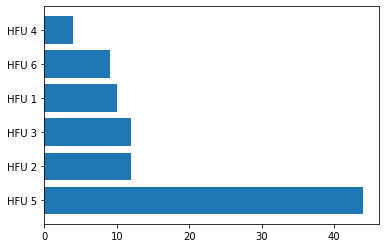

In [211]:
labels_freq = train_y.value_counts()
plt.barh(labels_freq.index, labels_freq)

In [242]:
labels_freq.index = range(6)
total = 91
class_weight = dict(labels_freq.apply(lambda x : (1 / x) * (total/10)))
class_weight

{0: 0.20681818181818182,
 1: 0.7583333333333333,
 2: 0.7583333333333333,
 3: 0.91,
 4: 1.011111111111111,
 5: 2.275}

## Modelling

### With Labeling Encoding of target

In [236]:
label_map = dict(zip(['HFU 1', 'HFU 2', 'HFU 3', 'HFU 4', 'HFU 5', 'HFU 6'], range(1,7)))
train_y_label = train_y.map(label_map)
test_y_label = test_y.map(label_map)

In [240]:
rf_model = RandomForestClassifier() #class_weight=class_weight)
rf_model.fit(train_X, train_y_label)
rf_preds = rf_model.predict(test_X)
show_results(test_y_label, rf_preds)

,0
Accuracy,0.500000
F1 Score,0.435871


In [195]:
nn_model = Sequential()
dimensions = train_X.shape[1]
n_labels = train_y_label.nunique()
nn_model.add(Dense(256, activation='relu', input_shape=(dimensions,)))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(n_labels, activation='softmax'))

nn_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 metrics=['accuracy'])

history = nn_model.fit(train_X, train_y_label, validation_split=0.2, epochs=20)

test_loss, test_accuracy = nn_model.evaluate(test_images, test_labels)
                    
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

nn_preds = nn_model.predict(test_X)
show_results(test_y_label, nn_preds)

Epoch 1/20


InvalidArgumentError:  Received a label value of 6 which is outside the valid range of [0, 6).  Label values: 5 5 1 5 5 1 5 5 5 5 6 5 1 5 5 3 5 1 2 5 5 3 5 1 6 4 5 5 5 5 2 3
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\backend.py:5113)
]] [Op:__inference_train_function_721]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\backend.py:5109)	
In[1] sparse_categorical_crossentropy/Reshape (defined at C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\BABBAN~1\AppData\Local\Temp/ipykernel_2996/635850497.py", line 11, in <module>
>>>     history = nn_model.fit(train_X, train_y_label, validation_split=0.2, epochs=20)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\engine\training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "C:\Users\Babban Gona\Anaconda3\lib\site-packages\keras\backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

### With One Hot Encoding of target

In [243]:
label_bin = LabelBinarizer()

train_y_label = label_bin.fit_transform(train_y)
test_y_label = label_bin.fit_transform(test_y)

In [260]:
nn_model = Sequential()
dimensions = train_X.shape[1]
n_labels = y.nunique()
nn_model.add(Dense(10, activation='relu', input_shape=(dimensions,)))
#nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(n_labels, activation='softmax'))

nn_model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(),
 metrics=['accuracy'])
early_stop = EarlyStopping(patience=2)

history = nn_model.fit(train_X, train_y_label, validation_split=0.2, epochs=20,
                       callbacks=[early_stop],) #class_weight=class_weight)

nn_preds = nn_model.predict(test_X)

Epoch 1/20
3/3 [==============================] - 0s 52ms/step - loss: 186.5467 - accuracy: 0.1111 - val_loss: 175.0625 - val_accuracy: 0.1053
Epoch 2/20
3/3 [==============================] - 0s 12ms/step - loss: 178.4729 - accuracy: 0.1111 - val_loss: 167.1792 - val_accuracy: 0.1053
Epoch 3/20
3/3 [==============================] - 0s 17ms/step - loss: 170.5713 - accuracy: 0.1111 - val_loss: 159.6068 - val_accuracy: 0.1053
Epoch 4/20
3/3 [==============================] - 0s 11ms/step - loss: 162.9875 - accuracy: 0.1111 - val_loss: 151.8474 - val_accuracy: 0.1053
Epoch 5/20
3/3 [==============================] - 0s 15ms/step - loss: 155.1526 - accuracy: 0.1111 - val_loss: 144.3186 - val_accuracy: 0.1053
Epoch 6/20
3/3 [==============================] - 0s 12ms/step - loss: 147.4418 - accuracy: 0.1111 - val_loss: 136.8086 - val_accuracy: 0.1053
Epoch 7/20
3/3 [==============================] - 0s 10ms/step - loss: 139.8729 - accuracy: 0.1111 - val_loss: 129.9357 - val_accuracy: 0.1053

In [261]:
def extract_classes(data_df, base_score=0.5):
    data_df = data_df.applymap(lambda x : 1 if x > base_score else 0)
    return data_df

In [262]:
extract_classes(nn_preds_df, 0.2)

,0,1,2,3,4,5
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0
5,0,0,0,0,1,0
6,0,0,0,0,1,0
7,0,0,0,0,1,0
8,0,0,0,0,1,0
9,0,0,0,0,1,0
